# BackProb in Multilayer Perceptron NN

In [2]:
import seaborn as sb
import numpy as np
import pdb
import pickle as pkl
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from tqdm import tqdm
import argparse
import sys
import os

/home/chahuja/env/tf/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [3]:
# Load Data
np.random.RandomState(212)
train = np.matrix(np.genfromtxt('digitstrain.txt', delimiter=','))
np.random.shuffle(train) ## Shuffle to improve convergence
test = np.matrix(np.genfromtxt('digitstest.txt', delimiter=','))
val = np.matrix(np.genfromtxt('digitsvalid.txt', delimiter=','))

In [4]:
# Prepare data for training, validation and testing
NUM_CLASSES = 10 ## hardcoded
## converting ground truths to one-hot encoding
def cat_to_one_hot(vec):
  vec = vec.astype(int) ## changing type to int as these are indices for the one-hot vector
  return np.matrix(np.eye(NUM_CLASSES)[vec])

train_gt = cat_to_one_hot(train[:,-1])
test_gt = cat_to_one_hot(test[:,-1])
val_gt = cat_to_one_hot(val[:,-1])

train = train[:,:-1]
test = test[:,:-1]
val = val[:,:-1]

## Plotting Image of a training input

In [5]:
# Plotting the image 
## The data is in row-major format
def plot_image(train):
  plt.imshow(train[0].reshape((28,28)))
## The image is squeezed row-wise

In [6]:
# Basic loss/activation functions and their gradients which are codenamed "inv"
# These functions are defined with input as numpy.matrix format.
# things may go haywire if numpy.array is used 
# even though numpy.matrix inherits properties from numpy.array
def cross_entropy_loss(vec, gt):
  return -np.multiply(gt,np.log(vec)).sum()/vec.shape[0] ## take the average

def classification_error(vec,gt):
  #pdb.set_trace()
  dif = abs(np.argmax(vec,axis=1)-np.argmax(gt,axis=1))
  err = np.ceil((1.0*dif)/max(dif))
  relative_err = (1.0*err.sum())/len(err)
  return relative_err*100

def sigmoid(mat):
  return 1./(1+ np.exp(-mat))

def inv_sigmoid(mat):
  return np.multiply(sigmoid(mat),(1-sigmoid(mat)))

def softmax(vec):
  return np.concatenate(
    tuple([np.exp(vec[i,:])*1./np.exp(vec[i,:]).sum() for i in range(vec.shape[0])])
    , axis = 0)

def inv_softmax_with_loss(vec, gt):
  # gt - ground truth in one hot vector format
  if (vec.shape != gt.shape):
    raise Exception("Prediction and Expected Values must have the same dimensions")
    
  return softmax(vec) - gt

def relu(value):
  if (value<=0):
    return 0
  else:
    return value

def dropout_mask_forward(prob, dim):
  if (prob>1 or prob<0):
    raise Exception("Probability has to be between 0 and 1")

  ## in the forward pass, the mask has the probability of the selection of the node
  ## while in the backward pass, the mask has value 1 for "prob" fraction of the elements
  forward_mask = np.matrix(np.ones((1,dim)) * prob * 1.0)
  forward_mask = np.concatenate((forward_mask, np.matrix([1])), axis=1)
  return forward_mask

def dropout_mask_backprob(prob, dim):
  if (prob>1 or prob<0):
    raise Exception("Probability has to be between 0 and 1")
  #backprob_mask = np.matrix([1 for _ in range(int(np.ceil(prob*dim)))]+ [0 for _ in range(int(dim - np.ceil(prob*dim)))])
  backprob_mask = np.abs(np.ceil(prob - np.random.uniform(size=(1,dim))))
  np.random.shuffle(backprob_mask.T) ## random placement of ones
  backprob_mask = np.concatenate((backprob_mask,np.matrix([1])), axis=1)
  return backprob_mask

def copy_list(a):
  return [a[i].copy() for i in range(len(a))]
  

## Visualization

In [7]:
## Visualizing filters
def vis(model, save_name):
  dim = model.weights[0].shape[1]
  n_image_rows = int(np.ceil(np.sqrt(dim)))
  n_image_cols = int(np.ceil(dim * 1.0/n_image_rows))
  gs = gridspec.GridSpec(n_image_rows,n_image_cols,top=1., bottom=0., right=1., left=0., hspace=0., wspace=0.)
  for g,count in zip(gs,range(int(dim))):
    ax = plt.subplot(g)
    ax.imshow(model.weights[0][:-1,count].reshape((28,28)))
    ax.set_xticks([])
    ax.set_yticks([])
  plt.savefig(save_name + '_vis.png')

def plot_cce(model, save_name):  
  train_plt = plt.plot(range(len(model.hist.train_loss)),model.hist.train_loss, 'r--', label='Train')
  val_plt = plt.plot(range(len(model.hist.val_loss)),model.hist.val_loss, 'g-', label="Val")
  plt.xlabel('No. of Epochs')
  plt.ylabel('mean(Entropy Loss)')
  plt.savefig(save_name+'.png')

def plot_err(model, save_name):  
  train_plt = plt.plot(range(len(model.hist.train_loss)),model.hist.train_class_loss, 'r--', label='Train')
  val_plt = plt.plot(range(len(model.hist.val_loss)),model.hist.val_class_loss, 'g-', label="Val")
  plt.xlabel('No. of Epochs')
  plt.ylabel('Classification Error')
  plt.savefig(save_name+'_err.png')

## Gradient Check

In [8]:
def gradient_check(model, X, gt, ep = 0.0001):
  ## Estimate the gradients using first principles
  grad_W_cap = list()
  for layer in range(model.num_layers):
    ## add a zero matrix which will be updated with estimated gradients
    grad_W_cap.append(np.matrix(np.zeros_like(model.weights[layer])))
    for index, _ in tqdm(np.ndenumerate(model.weights[layer])):
      ## Increase the model weights by epsilon (a.k.a ep)
      ## and calculate the loss function L(w+ep)
      old_weight = model.weights[layer][index]
      model.weights[layer][index] += ep
      L_x_plus_ep = cross_entropy_loss(model.forward(X,activation=True),gt)
      model.weights[layer][index] = old_weight
      ## Decrease the model weights by epsilon (a.k.a ep)
      ## and calculate the loss function L(w-ep)
      model.weights[layer][index] -= ep
      L_x_minus_ep = cross_entropy_loss(model.forward(X,activation=True),gt)
      model.weights[layer][index] = old_weight
      
      ## Update the estimated gradient in the grad_W_cap list
      ## We use log wise addition as the denominater is fairly small 
      ## which might result in precision errors
      grad_W_cap[layer][index] = np.exp(np.log(L_x_plus_ep - L_x_minus_ep) - np.log(2*ep))
  return grad_W_cap
  ## Plot Heatmaps of (grad_W  - grad_W_cap)
  for layer in range(model.num_layers):
    sb.heatmap(model.grad_W[layer] - grad_W_cap[layer])
  pdb.set_trace()

In [9]:
## gradient check
def grad_check(model):
  layer = 0
  sb.heatmap(model.grad_W[layer] - grad_W_cap[layer])

## Saving and loading the model

In [10]:
def save_model(model, filename):
  fl = open(filename,'wb')
  pkl.dump(model,fl)
  
def load_model(filename):
  fl = open(filename, 'rb')
  return pkl.load(fl)

## Loss History Class


In [11]:
class history(object):
  def __init__(self):
    self.train_loss = list()
    self.val_loss = list()
    self.train_class_loss = list()
    self.val_class_loss = list()

  def add(self,train_loss, val_loss,train_class_loss,val_class_loss):
    self.train_loss.append(train_loss)
    self.val_loss.append(val_loss)
    self.train_class_loss.append(train_class_loss)
    self.val_class_loss.append(val_class_loss)

## Model class NN
```sh
graph - [num_nodes(int), num_nodes(int), ...]
each layer ends with sigmoid
graph ends with softmax and crossentropy loss
```

In [16]:
class NN(object):
  def __init__(self,graph,state):
    self.graph = graph
    self.weights = list()
    self.weights_optimal = list() ## to store the optimal weights
    self.hist = history()
    self.v = list() ## momentum
    self.stopping_count = 0
    
    prev_dim = -1
    for dim in self.graph:
        if (prev_dim > 0):
          # set the high and low bounds for the random initialization 
          # based on glorot's rule
          high = np.sqrt(6.0/(prev_dim + dim))
          low = -high
          # prev_dim + 1 to include a row for bias 
          self.weights.append(state.uniform(low=low,high=high,size=(prev_dim+1,dim)))
          ## momentum has the same dimension as the weight matrices
          self.v.append(np.matrix(np.zeros_like(self.weights[-1])))
        prev_dim = dim
    
    self.num_layers = len(self.weights)
    self.weights_optimal = copy_list(self.weights)

  ## to restore optimal weights when restoring a model
  def restore_optimal_weights(self):
    self.weights = copy_list(self.weights_optimal)
    
  def plot(self):
    #sb.pointplot(x="num_epochs", y="entropy_loss", data=[self.hist.train_loss,self.hist.val_loss]);
    plt.plot(self.hist.train_loss,range(len(self.hist.train_loss)), 'r--')
    plt.plot(self.hist.val_loss,range(len(self.hist.val_loss)), 'g+-')

  def forward(self,X,limit = 0, activation = False, prob=1):
    # We use the forward function to calculate the forward prop
    ## while training the model, various segments of the forward prop are required
    ## which need to be extracted at the right times
    # "limit" and "activation" define the layers that have to be removed from the end
    ## limit = 0 and activation=True implies complete calculation
    ## limit = 0 and activation=False ignores the softmax function but calculates till last layer
    ## limit = 1 and activation=True implies calculation till second-last layer w/ sigmoid
    ## limit = 1 and activation=False implies calculation till second-last layer w/o sgimoid
    ## now the limit belongs to [0,len(NN.weights)-1], hence with other values it will give junk
    ## also for dropout we define a parameter called "prob" which defines the fraction of the 
    ## nodes to be active during training
    # raise havoc if the limits are not correct
    if(limit > self.num_layers or limit < 0):
      raise Exception("Limits of the network are out of bounds")
    # add a column of ones to take care of the bias only if we do not need the input layer
    if((limit == self.num_layers and activation == True) or limit < self.num_layers):
      X = np.concatenate((X,np.ones_like(X[:,0])), axis = 1)
    # Converting input to matrix form
    X = np.mat(X)
    
    # limits
    ## 0 -> -1
    ## 1 -> -1
    ## 2 -> -2 and so on which generalizes to relu(limit-1)-1
    limits = range(self.num_layers-relu(limit-1)-1)
    for k in limits:
      X = X*np.mat(self.weights[k]) ## Linear
      ## if activation=False skip the non-linear part
      ## if k is the final element of the limits only then break 
      ## if limit is not 0, then all the layers must be taken into consideration
      if (activation == False and k == limits[-1] and limit != 0):
        break
      X = sigmoid(X) ## Non-Linear
      X = np.concatenate((X,np.ones_like(X[:,0])), axis = 1)
      forward_mask = dropout_mask_forward(prob=prob, dim=X.shape[1]-1) ## subtract 1 due to the bias
      X = np.multiply(X, forward_mask)
      
    # if the limit is anything apart the last layer, return the calculated values
    if (limit > 0):
      return X
    
    X = X*np.mat(self.weights[-1]) ## Linear
    if (activation == True):
      return softmax(X) ## Non-Linear
    else: 
      return X
  
  # implements one iteration of backpropogation through the network
  ## it has to use forward() to estimate gradient values at each layer
  ## the gradient values for every matrix are returned as a list of matrices
  ## which will be used for optimizing the model via stochastic/batch/mini-batch descent
  # Note: the gradients are calculated based on the original set of weights provided as X
  ## and all the weights ar updated at the end of a complete back prob
  # -------------------------------------------------------------------------------
  # Variables
  # ---------
  # grad_W = gradients w.r.t. weights including bias
  # grad_H = gradients w.r.t. hidden layers
  # grad_A = gradients w.r.t. pre-activation layer
  # All of these variables are lists and updated as the backprob traverses through 
  ## different layers
  # -------------------------------------------------------------------------------
  def backprob(self, X, gt, prob=1, lam=0):
    self.grad_W = list()
    grad_H = list()
    grad_A = list()
    
    ## initializing first gradient
    grad_A.append(inv_softmax_with_loss(self.forward(X, prob=prob), gt))
    for k in range(self.num_layers):
      ## Calculating the forward pass
      forward_pass = self.forward(X, k+1, True, prob=prob)
      backprob_mask = dropout_mask_backprob(prob=prob, dim=forward_pass.shape[1]-1) ## subtract 1 due to the bias
      #masked_input = forward_pass
      #backprob_mask = np.matrix(np.ones_like(forward_pass))
      masked_input = np.multiply(forward_pass,backprob_mask)
      mod_w = np.abs(self.weights[self.num_layers-k-1])
      mod_w[-1] = 0 ## as the bias should not be regularized
      self.grad_W.append(masked_input.T * grad_A[k] - lam*mod_w)
      ## We do not need the bias layer to update the gradients so we do not keep it
      grad_H.append(self.weights[self.num_layers-k-1][:-1,:] * grad_A[k].T) 
      grad_A.append(np.multiply(grad_H[k].T,inv_sigmoid(self.forward(X,k+1, prob=prob))))

    ## reverse the list of gradients as they were stored in the order of backprob
    self.grad_W.reverse()
    
  ## gradient updates which requires learning rate(lr) and momentum(mm)
  def grad_descent(self, X, gt, lr=0.1, mm=0, prob=1, lam=0, optimal_limit=False):
    if(not optimal_limit):
      self.weights_optimal = copy_list(self.weights)
      
    ## calculating gradients
    self.backprob(X, gt, prob, lam)
    ## updating gradients
    for k in range(self.num_layers):
      self.v[k] = self.v[k] * mm - lr * self.grad_W[k]
      self.weights[k] = self.weights[k] + self.v[k]

In [27]:
def sgd_train(args):
  ## Random Seed
  state = np.random.RandomState(args.seed)
  model = NN(args.graph, state)
  
  ## load the first weight matrix -- Hardcoded #########################################
  if (args.weight_file is not None):
    print("Loading weights")
    W = load_model(args.weight_file)
    model.weights[0][:-1,:] = W[0].T
    model.weights[0][-1,:] = W[1].T
  ######################################################################################
  
  # SGD
  prob = args.prob ## Dropout coeffiecient
  lam = args.lam ## regularization coeffiecient
  lr = args.lr
  mm = args.mm 
  optimal_limit = False
  
  ## automatic unique name creation
  save_name = "%s_lr%d_mm%d_lam%d_dropout%d_" %(args.save_dir,args.lr*1000,args.mm*1000,args.lam*1000,args.prob*10)
  graph_name_temp = [str(args.graph[0])]
  for num_layers in range(1,len(args.graph)):
    graph_name_temp.append("_%d" %args.graph[num_layers])
  graph_name = ''
  for i in range(len(graph_name_temp)):
    graph_name+=graph_name_temp[i]
  save_name += graph_name
  save_name = os.path.join(args.save_dir,save_name)
  
  for i in tqdm(range(args.num_epochs)):
    for j in range(train.shape[0]):
      model.grad_descent(train[j], train_gt[j], lr=lr, mm=mm, prob=prob, lam=lam, optimal_limit=optimal_limit)
    train_pred = model.forward(train,activation=True, prob=prob)
    val_pred = model.forward(val,activation=True, prob=prob)
    train_class_loss = classification_error(train_pred,train_gt)
    val_class_loss = classification_error(val_pred,val_gt)
    model.hist.add(cross_entropy_loss(train_pred, train_gt),
                  cross_entropy_loss(val_pred, val_gt), train_class_loss, val_class_loss)
    
    try:
      if (model.hist.val_loss[-2] < model.hist.val_loss[-1]):
        optimal_limit = True
        ## Run the training for some more epochs after overfitting starts
        model.stopping_count+=1
        if (model.stopping_count >=5 and args.early_stopping == True):
          break
      else:
        optimal_limit = False
        model.stopping_count = 0 ## Reset the stopping count
    except:
      pass
      
    print("train error: %f, %f") %(model.hist.train_loss[-1],model.hist.train_class_loss[-1])
    print("val error: %f, %f") %(model.hist.val_loss[-1],model.hist.val_class_loss[-1])
    save_model(model,save_name+'.p')
    
  ## Error vs Epochs
  plot_cce(model, save_name)
  plot_err(model, save_name)
  vis(model, save_name)
  ## print test scores at the end
  ## Print the test scores
  test_pred = model.forward(test,activation=True, prob=args.prob)
  print("test error: %f, %f") %(cross_entropy_loss(test_pred,test_gt),classification_error(test_pred,test_gt))


In [28]:
def main():
    parser = argparse.ArgumentParser()
    parser.add_argument('--save_dir', type=str, default='save',
                        help='directory to store checkpointed models')
    parser.add_argument('--graph', type=int ,nargs='+', default=[784,100,10],
                        help='Structure of the NN') 
    parser.add_argument('--prob', type=float, default=1,
                        help='dropout coefficients')
    parser.add_argument('--lam', type=float, default=0,
                        help='regularizing coefficient')
    parser.add_argument('--lr', type=float, default=0.01,
                        help='learning rate')
    parser.add_argument('--mm', type=float, default=0,
                        help='momentum')
    parser.add_argument('--num_epochs', type=int, default=50, 
                        help='number of epochs')
    parser.add_argument('--seed', type=int, default=212, 
                        help='Random Seed')
    parser.add_argument('--early_stopping', type=bool, default=True,
                        help='If you want to perform early stopping')
    parser.add_argument('--weight_file', type=str, default=None,
                        help='weight file')
    args = parser.parse_args()
    try:
      os.makedirs(args.save_dir)
    except:
      pass
    sgd_train(args)

  0%|          | 0/1 [00:00<?, ?it/s]

Loading weights


100%|██████████| 1/1 [00:19<00:00, 19.59s/it]

train error: 0.526880, 13.466667
val error: 0.572586, 14.900000


test error: 0.608760, 17.000000


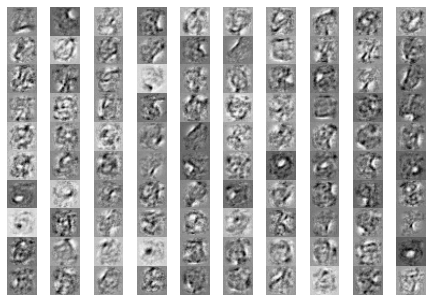

In [29]:
sys.argv=['train.py',
         '--save_dir','m1',
         '--graph', '784', '100', '10',
         '--prob', '1',
         '--lam', '0',
         '--lr', '0.01',
         '--mm', '0',
         '--num_epochs', '1',
         '--early_stopping', 'True', 
         '--seed', '212',
         '--weight_file','a1/a1_k1_graph_100weights.p']
if __name__=="__main__":
  main()